In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [2]:
import monalysa
from monalysa import movements
from monalysa import quality

In [3]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight

In [4]:
base_fig_dir = pathlib.Path.cwd().parent / "figures"

## Demonstration of limits of sequences of movements

In [5]:
def twosub_move(a1, a2, tstrt1, tstrt2, tstp1, tstp2, T, dt):
    """Generates a movement with two submovements with the given amplitudes,
    start times and stop times."""
    t = np.arange(0, T, dt)
    if tstrt1 < tstp1: 
        m1 = movements.mjt_discrete_movement(a1, dur=tstp1 - tstrt1, 
                                             loc=0.5 * (tstp1 + tstrt1),
                                             time=t)
    else:
        m1 = np.zeros(t.shape)
    if tstrt2 < tstp2:
        m2 = movements.mjt_discrete_movement(a2, dur=tstp2 - tstrt2, 
                                             loc=0.5 * (tstp2 + tstrt2),
                                             time=t)
    else:
        m2 = np.zeros(t.shape)
    return t, m1 + m2

In [6]:
def moveindicator(m, th=0):
    """A movement indicator function that returns 1 if there is a movement
    as defined by the threshold th, and 0 otherwise."""
    return (m > th).astype(int)

def moveint(m, th, dt):
    """A movement interval function that returns the temporal interval of the 
    given movement."""
    _mi = np.where(moveindicator(m, th) == 1)[0]
    return (np.min(_mi) - 1) * dt, (np.max(_mi) + 1) * dt

def movedur(m, th, dt):
    """A movement duration function that returns the duration of the given 
    movement."""
    return moveint(m, th, dt)[1] - moveint(m, th, dt)[0]

In [21]:
def stdist(move1, move2, th, dt):
    """Computes the spatio-temporal distance between two movements.
    """
    # Movement durations for the two movements
    dur1 = movedur(move1, 0, dt)
    dur2 = movedur(move2, 0, dt)
    # Spatial distance
    _sdist = np.linalg.norm(move1 - move2, ord=2) * dt
    # spatial weight
    ws = 1 / ((np.linalg.norm(move1, ord=2) + np.linalg.norm(move2, ord=2)) * dt)
    # Temporal distance
    _tdist = np.abs(dur1 - dur2)
    # temporal weight
    wt = 1 / (dur1 + dur2)
    return ws * _sdist + wt * _tdist

### Changing amplitude, fixed temporal parameters

In [22]:
T = 2.0
dt = 0.001
time = np.arange(0, T, dt)
# Reference movement
move_ref = movements.mjt_discrete_movement(1, dur=1, loc=0.5, time=time)

In [51]:
# Generate the squence of movements
a2 = 1/ np.arange(1, 1000)
move1_k = [twosub_move(a1=1, a2=_a2, tstrt1=0., tstrt2=1.,
                       tstp1=1., tstp2=2, T=2, dt=0.001)[1] for _a2 in a2]

### Changing start time, fixed amplitude and duration

In [56]:
tstrt2 = 2 - 1/ np.array([np.power(2, _n) for _n in range(0, 12, 1)])
# Generate the squence of movements
move2_k = [twosub_move(a1=1, a2=2 - _ts, tstrt1=0., tstrt2=_ts,
                       tstp1=1., tstp2=2, T=2, dt=0.001)[1] for _ts in tstrt2]

### Changing duration, fixed amplitude and start time

In [57]:
tstp2 = 1 + 1/ np.arange(1, 1000)
# Generate the squence of movements
move3_k = [twosub_move(a1=1, a2=_ts - 1, tstrt1=0., tstrt2=1.0,
                       tstp1=1., tstp2=_ts, T=2, dt=0.001)[1] for _ts in tstp2]

In [58]:
# Compute spatio-temporal distances
stdist1 = [stdist(move_ref, _m, 0, dt) for _m in move1_k]
stdist2 = [stdist(move_ref, _m, 0, dt) for _m in move2_k]
stdist3 = [stdist(move_ref, _m, 0, dt) for _m in move3_k]

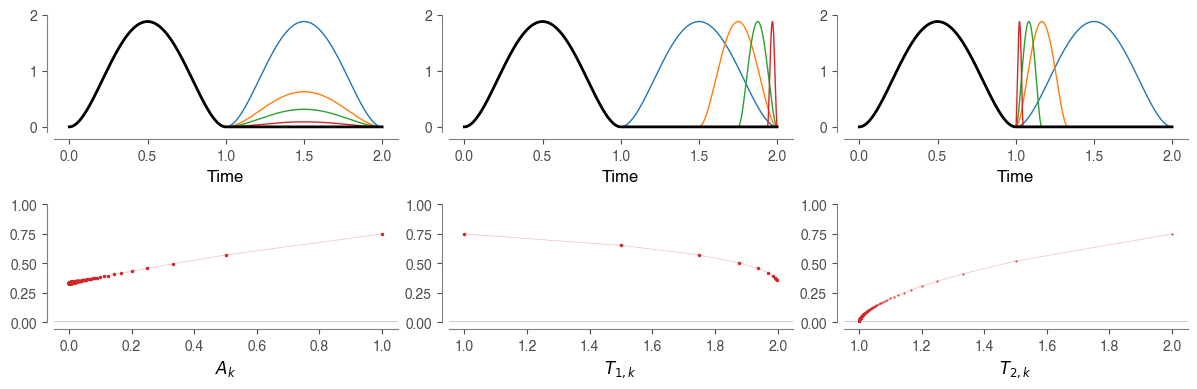

In [59]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(231)
ax.plot(time, move1_k[0], lw=1)
ax.plot(time, move1_k[2], lw=1)
ax.plot(time, move1_k[5], lw=1)
ax.plot(time, move1_k[20], lw=1)
ax.plot(time, move_ref, 'k', lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(232)
ax.plot(time, move2_k[0], lw=1)
ax.plot(time, move2_k[1], lw=1)
ax.plot(time, move2_k[2], lw=1)
ax.plot(time, move2_k[4], lw=1)
ax.plot(time, move_ref, 'k', lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(233)
ax.plot(time, move3_k[0], lw=1)
ax.plot(time, move3_k[2], lw=1)
ax.plot(time, move3_k[5], lw=1)
ax.plot(time, move3_k[20], lw=1)
ax.plot(time, move_ref, 'k', lw=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.set_ylim(-0.1, 2)
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel("Time", fontsize=12)

ax = fig.add_subplot(234)
ax.plot(a2[:-2], stdist1[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(a2[:-2], stdist1[:-2], ".", markersize=3, color="tab:red")
ax.axhline(0, color='0.0', lw=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$A_{k}$", fontsize=12)

ax = fig.add_subplot(235)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstrt2[:-2], stdist2[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstrt2[:-2], stdist2[:-2], ".", markersize=3, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{1,k}$", fontsize=12)

ax = fig.add_subplot(236)
ax.axhline(0, color='0.0', lw=1)
ax.plot(tstp2[:-2], stdist3[:-2], lw=0.5, alpha=0.3, color="tab:red")
ax.plot(tstp2[:-2], stdist3[:-2], ".", markersize=1, color="tab:red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.set_ylim(0.0, 1.0)
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_xlabel(r"$T_{2, k}$", fontsize=12)

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"move_seq_connvrg.svg"), bbox_inches="tight")

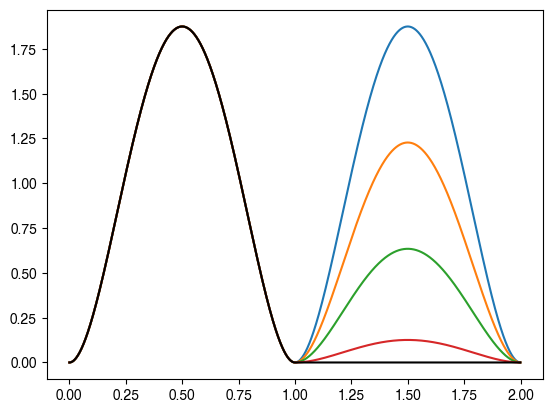

In [36]:
plt.plot(time, move1_k[0])
plt.plot(time, move1_k[345])
plt.plot(time, move1_k[661])
plt.plot(time, move1_k[932])
plt.plot(time, move_ref, 'k')

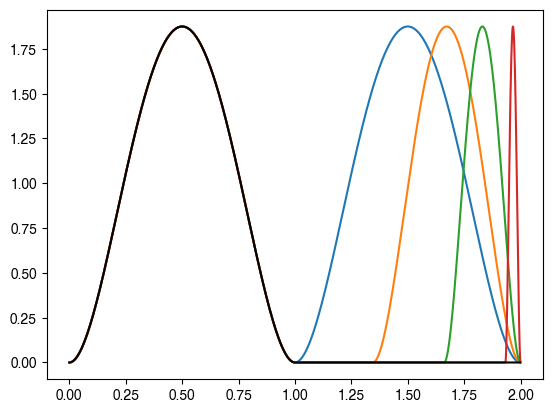

In [63]:
plt.plot(time, move2_k[0])
plt.plot(time, move2_k[345])
plt.plot(time, move2_k[661])
plt.plot(time, move2_k[932])
plt.plot(time, move_ref, 'k')

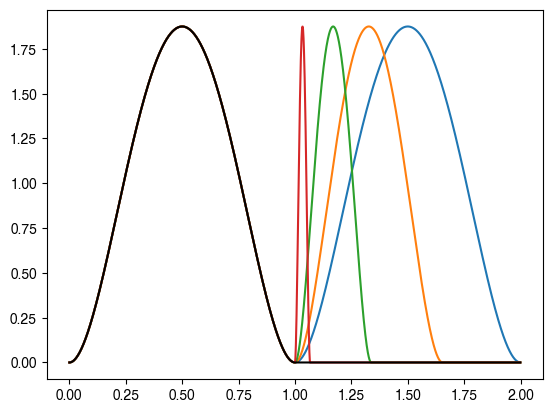

In [65]:
plt.plot(time, move3_k[0])
plt.plot(time, move3_k[345])
plt.plot(time, move3_k[661])
plt.plot(time, move3_k[932])
plt.plot(time, move_ref, 'k')

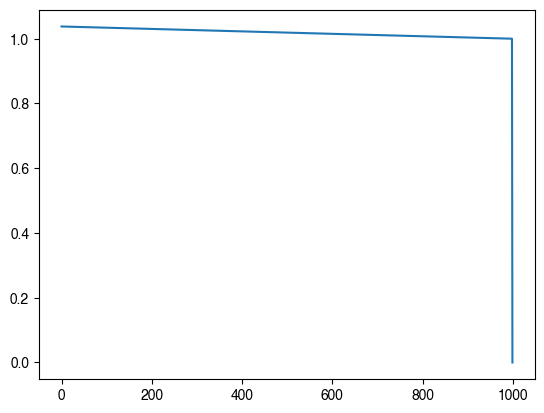

In [55]:

plt.plot(stdist_k)

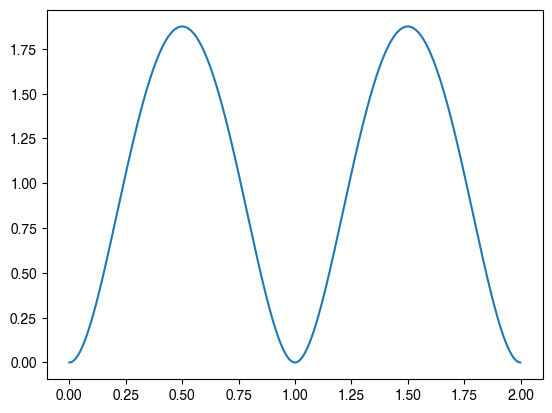

In [22]:
t, move = twosub_move(a1=1, a2=1, tstrt1=0., tstrt2=1., 
                      tstp1=1., tstp2=2, T=2, dt=0.001)
plt.plot(t, move)

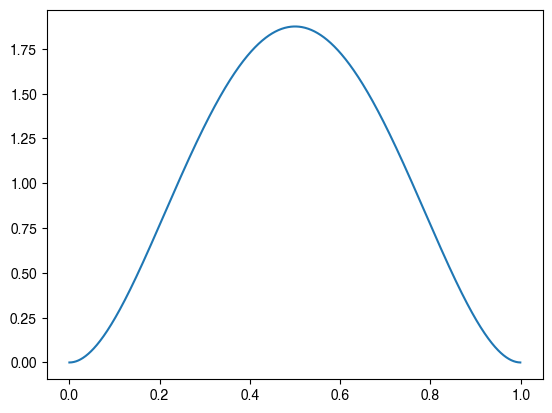

In [13]:
_t = np.arange(0, 1, 0.001)
plt.plot(_t, movements.mjt_discrete_movement(1, dur=1, loc=0.5, time=_t))

In [15]:
_t, _vel, _ = movements.generate_random_movement(move_type='Gaussian')
vel1 = np.hstack((np.zeros(40), _vel, np.zeros(25)))
dt = 0.01
T = len(vel1) * dt
t = np.arange(0, T, dt)
pos1 = 1.0 + np.cumsum(vel1) * dt

# Movement interval
_mi = 1.0* (vel1 > 0.01)
_tstrt = np.where(np.diff(_mi) == 1)[0]
_tstp = np.where(np.diff(_mi) == -1)[0]

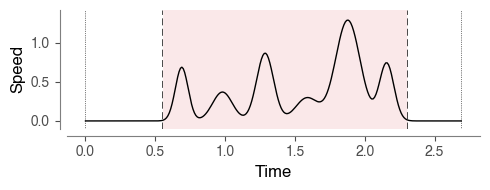

In [16]:
fig = plt.figure(figsize=(5, 2))

# Velocity plot
ax = fig.add_subplot(111)
ax.plot(t, vel1, color='k', lw=1)
# ax.step(t, _mi, color='tab:red', lw=1, alpha=0.2)
ax.fill(t, 10 * _mi - 5, color='tab:red', lw=0, alpha=0.1)
ax.axvline(t[_tstrt[0]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(t[_tstp[-1]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(0, color='black', lw=0.5, ls="dotted")
ax.axvline(t[-1], color='black', lw=0.5, ls="dotted")
# ax.set_xlim(0, T)
ax.set_ylim(-0.1, 1.1 * max(vel1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Speed", fontsize=12)
ax.set_xlabel("Time", fontsize=12)

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.svg"), bbox_inches="tight")


## Demonstration of Spatiotemporal Distance 

In [17]:
moves = {}

# Case 1
dt = 0.01
t = np.arange(0, 3 + dt, dt)
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")
m2 = (m1 + np.random.normal(0, 0.5, len(m1))) * (m1 > 0)
m2 = np.abs(signal.savgol_filter(m2, window_length=21, polyorder=1, mode="constant")) * (m1 > 0)
m3 = movements.mjt_discrete_movement(amp=1, dur=1.25, loc=0.625, time=t, data_type="vel")
moves['case1'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
    "m3": m3,
}

# Case 2
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")
m2 = m1 + movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=1.75, time=t, data_type="vel")
m3 = m1 + movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=2.5, time=t, data_type="vel")
moves['case2'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
    "m3": m3
}


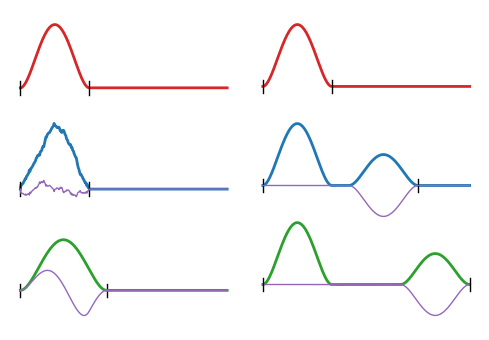

In [18]:
fig = plt.figure(figsize=(5, 3.5))
ydel = 3.0
ax = fig.add_subplot(121)
ax.plot(moves["case1"]["t"], moves["case1"]["m1"], color='tab:red',
        lw=2, label="$m_1$")
ax.plot([0, 0], [-0.2, 0.2], lw=1, color='k')
ax.plot([1, 1], [-0.2, 0.2], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m2"] - ydel, color='tab:blue',
        lw=2, label="$m_2$")
ax.plot([0, 0], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot([1, 1], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m2"] - ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot([0, 0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot([1.25, 1.25], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot(moves["case1"]["t"], moves["case1"]["m3"] - 2 * ydel, color='tab:green',
        lw=2, label="$m_2$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m3"] - 2 * ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axis('off')

ax = fig.add_subplot(122)
ax.plot(moves["case2"]["t"], moves["case2"]["m1"], color='tab:red',
        lw=2, label="$m_1$")
ax.plot([0, 0], [-0.2, 0.2], lw=1, color='k')
ax.plot([1, 1], [-0.2, 0.2], lw=1, color='k')
ax.plot(moves["case2"]["t"], moves["case2"]["m2"] - ydel, color='tab:blue',
        lw=2, label="$m_2$")
ax.plot([0, 0], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot([2.25, 2.25], [-0.2 - ydel, 0.2 - ydel], lw=1, color='k')
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m2"] - ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot(moves["case2"]["t"], moves["case2"]["m3"] - 2 * ydel, color='tab:green',
        lw=2, label="$m_2$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m3"] - 2 * ydel, 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.plot([0, 0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.plot([3.0, 3.0], [-0.2 - 2 * ydel, 0.2 - 2 * ydel], lw=1, color='k')
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist.svg"), bbox_inches="tight")

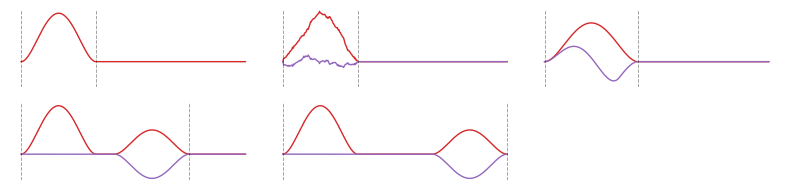

In [19]:
fig = plt.figure(figsize=(8, 2))
ax = fig.add_subplot(231)
ax.plot(moves["case1"]["t"], moves["case1"]["m1"], color='tab:red',
        lw=1, label="$m_1$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(232)
ax.plot(moves["case1"]["t"], moves["case1"]["m2"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m2"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(233)
ax.plot(moves["case1"]["t"], moves["case1"]["m3"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case1"]["t"], moves["case1"]["m1"] - moves["case1"]["m3"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(234)
ax.plot(moves["case2"]["t"], moves["case2"]["m2"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m2"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(2.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

ax = fig.add_subplot(235)
ax.plot(moves["case2"]["t"], moves["case2"]["m3"], color='tab:red',
        lw=1, label="$m_1$")
ax.plot(moves["case2"]["t"], moves["case2"]["m1"] - moves["case2"]["m3"], 
        color='tab:purple', lw=1, alpha=1, label="$m_1 - m_2$")
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(3.0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-1.0, 2.0)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new.svg"), bbox_inches="tight")

In [97]:
moves = {}

# Case 1
dt = 0.01
t1 = np.arange(0, 1 + dt, dt)
t2 = np.arange(0, 1.5 + dt, dt)
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t1, data_type="vel")
m1_hat = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel")
m2 = movements.mjt_discrete_movement(amp=1, dur=1.5, loc=0.75, time=t2, data_type="vel") 
m2 += 0 * np.random.normal(0, 0.5, len(m1_hat))
# m2 = np.abs(signal.savgol_filter(m2, window_length=21, polyorder=1, mode="constant"))
moves['case1'] = {
    "t1": t1,
    "t2": t2,
    "m1": m1,
    "m1_hat": m1_hat,
    "m2": m2
}

# Case 2
t1 = np.arange(0, 1.0 + dt, dt)
t2 = np.arange(0, 2.25 + dt, dt)
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t1, data_type="vel")
m1_hat = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel")
m2 = (movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel") + 
      movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=1.75, time=t2, data_type="vel"))
moves['case2'] = {
    "t1": t1,
    "t2": t2,
    "m1": m1,
    "m1_hat": m1_hat,
    "m2": m2,
}

# Case 3
t = np.arange(0, 1.0 + dt, dt)
m1 = movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")
m2 = m1 + 0.1 * movements.mjt_discrete_movement(amp=1, dur=0.3, loc=0.85, time=t, data_type="vel")
moves['case3'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
}


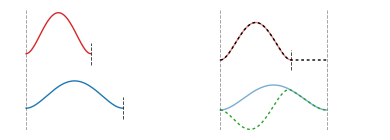

In [113]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot(121)
ax.plot(moves["case1"]["t1"], moves["case1"]["m1"], color='tab:red', lw=1, alpha=1)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - 2.5, color="tab:blue", lw=1)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.5, 1.5], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-3.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(122)
ax.plot(moves["case1"]["t1"], moves["case1"]["m1"], color='tab:red', lw=1, alpha=0.6)
ax.plot(moves["case1"]["t2"], moves["case1"]["m1_hat"], color='k', lw=1,
        ls="dashed", dashes=(2, 2))
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - 2.5, color="tab:blue", lw=1, alpha=0.6)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - moves["case1"]["m1_hat"]- 2.5,
        color="tab:green", lw=1, ls="dashed", dashes=(2, 2))
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.axvline(1.5, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.set_ylim(-3.5, 2.5)
ax.set_xlim(-0.25, 2.25)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new1.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new1.svg"), bbox_inches="tight")

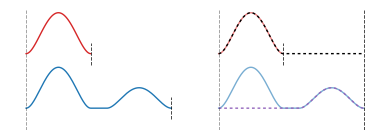

In [101]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot(121)
ax.plot(moves["case2"]["t1"], moves["case2"]["m1"], color='tab:red', lw=1, alpha=1)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - 2.5, color="tab:blue", lw=1)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([2.25, 2.25], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-3.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(122)
ax.plot(moves["case2"]["t1"], moves["case2"]["m1"], color='tab:red', lw=1, alpha=0.6)
ax.plot(moves["case2"]["t2"], moves["case2"]["m1_hat"], lw=1, color="k",
        ls="dashed", dashes=(2, 2))
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - 2.5, color="tab:blue", lw=1, alpha=0.6)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - moves["case2"]["m1_hat"]- 2.5,
        color="tab:purple", lw=1, ls="dashed", dashes=(2, 2))
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.axvline(2.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-3.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new2.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new2.svg"), bbox_inches="tight")

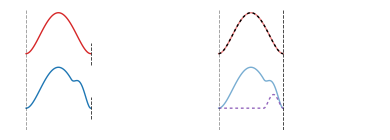

In [111]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot(121)
ax.plot(moves["case3"]["t"], moves["case3"]["m1"], color='tab:red', lw=1, alpha=1)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - 2.5, color="tab:blue", lw=1)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-3.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(122)
ax.plot(moves["case3"]["t"], moves["case3"]["m1"], color='tab:red', lw=1, alpha=0.6)
ax.plot(moves["case3"]["t"], moves["case3"]["m1"], lw=1, color="k",
        ls="dashed", dashes=(2, 2))
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - 2.5, color="tab:blue", lw=1, alpha=0.6)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - moves["case3"]["m1"]- 2.5,
        color="tab:purple", lw=1, ls="dashed", dashes=(2, 2))
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-3.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new3.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_new3.svg"), bbox_inches="tight")

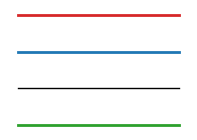

In [137]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot(121)
ax.plot([0, 1], [1, 1], color='tab:red', lw=2, alpha=1)
ax.plot([0, 1], [0, 0], color='tab:blue', lw=2, alpha=1)
ax.plot([0, 1], [-1, -1], color='k', lw=1)
ax.plot([0, 1], [-2, -2], color='tab:green', lw=2)
ax.axis('off')
plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_legend.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_legend.svg"), bbox_inches="tight")

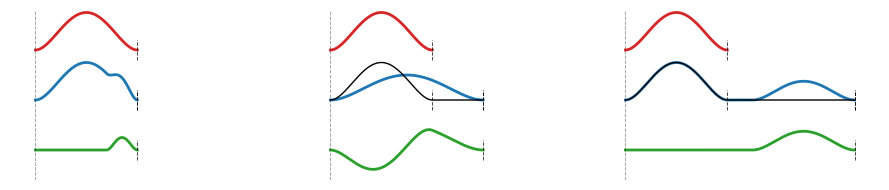

In [139]:
fig = plt.figure(figsize=(9, 2))
ax = fig.add_subplot(132)
ax.plot(moves["case1"]["t1"], moves["case1"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case1"]["t2"], moves["case1"]["m1_hat"] - 2.5, color='k', lw=1)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - moves["case1"]["m1_hat"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.5, 1.5], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.5, 1.5], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.5, 1.5], [-5.5, -4.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-6.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(133)
ax.plot(moves["case2"]["t1"], moves["case2"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case2"]["t2"], moves["case2"]["m1_hat"] - 2.5, color='k', lw=1)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - moves["case2"]["m1_hat"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([2.25, 2.25], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([2.25, 2.25], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([2.25, 2.25], [-5.5, -4.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-6.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(131)
ax.plot(moves["case3"]["t"], moves["case3"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - moves["case2"]["m1"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.plot([1.0, 1.0], [-0.5, 0.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-3.0, -2.0], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.plot([1.0, 1.0], [-5.5, -4.5], lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_ylim(-6.5, 2.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_plots.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_plots.svg"), bbox_inches="tight")